#### Compute Scores and Statistics

In [37]:
import re
import pandas as pd

def compute_bowling_stats_from_string(game_str: str) -> dict:
    """
    Safely score a 10‐frame bowling string via the numeric rolls list,
    avoiding any indexing of the raw string.
    """
     # 1) Build full roll list
    rolls = []
    for ch in game_str:
        if ch == "X":
            rolls.append(10)
        elif ch == "/":
            # spare: make up to 10
            rolls.append(10 - rolls[-1])
        elif ch in "-F":  # miss or foul
            rolls.append(0)
        else:
            rolls.append(int(ch))

    total, strikes, spares = 0, 0, 0
    pins_in_frame = 0
    roll_idx = 0

    # 2) Walk frame by frame
    for frame in range(1, 11):
        if game_str[roll_idx] == "X":
            # Strike frame
            strikes += 1
            total += 10
            # bonus: next two rolls
            total += rolls[roll_idx + 1] if roll_idx + 1 < len(rolls) else 0
            total += rolls[roll_idx + 2] if roll_idx + 2 < len(rolls) else 0
            pins_in_frame += 10
            roll_idx += 1

        else:
            # Two‐ball frame (might be spare)
            first = rolls[roll_idx]
            second = rolls[roll_idx + 1] if roll_idx + 1 < len(rolls) else 0

            if first + second == 10:
                # Spare
                spares += 1
                total += 10
                # bonus: next one roll
                total += rolls[roll_idx + 2] if roll_idx + 2 < len(rolls) else 0
            else:
                # Open frame
                total += first + second

            pins_in_frame += first + second
            roll_idx += 2
    return {
        "Total":    total,
        "Pins":     pins_in_frame,
        "Strikes":  strikes,
        "Spares":   spares
    }

def spare_transition_df(game_strings: list[str]) -> pd.DataFrame:
    """
    For each spare in each game, records:
      - first_throw: how many pins on the first ball
      - bonus:       pins scored on the next roll
    Returns a DataFrame one row per spare.
    """
    records = []
    for gs in game_strings:
        rolls = []
        # build rolls list again
        for ch in gs:
            if ch == 'X':
                rolls.append(10)
            elif ch == '/':
                rolls.append(10 - rolls[-1])
            elif ch in '-F':
                rolls.append(0)
            else:
                rolls.append(int(ch))
        # scan for spares in string
        for i, ch in enumerate(gs):
            if ch == '/':
                first = rolls[i-1]
                bonus = rolls[i+1] if i+1 < len(rolls) else None
                records.append({"first_throw": first, "bonus_throw": bonus})
    return pd.DataFrame(records)


def strike_transition_df(game_strings: list[str]) -> pd.DataFrame:
    """
    For each strike in each game, records:
      - bonus1: first bonus roll
      - bonus2: second bonus roll
    Returns a DataFrame one row per strike.
    """
    records = []
    for gs in game_strings:
        rolls = []
        for ch in gs:
            if ch == 'X':
                rolls.append(10)
            elif ch == '/':
                rolls.append(10 - rolls[-1])
            elif ch in '-F':
                rolls.append(0)
            else:
                rolls.append(int(ch))
        # scan for strikes
        idx = 0
        for i, ch in enumerate(gs):
            if ch == 'X':
                b1 = rolls[idx+1] if idx+1 < len(rolls) else None
                b2 = rolls[idx+2] if idx+2 < len(rolls) else None
                records.append({"bonus1": b1, "bonus2": b2})
                idx += 1
            else:
                idx += 1 if ch=='X' else 2  # skip two rolls for non-strike
    return pd.DataFrame(records)


# Example usage:
games = [
    "7/8-9/1/X628/458-33",
	"9/9/9/X8/9/34629-33",
	"617/817/189-9/9/817/X",
	"6/179/819-8/XX9-34",
	"X9-9/X9-X9-6/6352",
	"34725/7-8-61X9-X9-",
	"6/71XX8/X9-9/8-81",
	"6/71188--/7-X9/8/63",
	"X7-9-368-X9/818171",
	"459/81X9/X9/8/1/9/4",
	"455-72X6127X9/X36",
	"X6-8-5-7/-/17-1719-",
	"81144-429-8/54627117",
	"4/2/9-9-9/81X319/8-",
	"81519-9-4/7-9-34159F",
	"X62358-3/-37-X9-9/6",
	"9-9/9-9/3/279-5/-58/6",
	"729-9/8/9-7--9639-54",
	"17355/6/7/9-45X519-",
	"4/6312817/9/3/8/X9/8",
	"X3/9/617-6-71458/3/9",
	"9-9-7-717-9/63X7/7/8",
	"9-9-8/9-8-2-8/9-XX9/",
	"8-9/8/9/9/3272627281",
	"639/9-81X166-8-25X9-",
	"6-7/9/X1/-5X-5817/1",
	"345371-931X8-71X6/9"
]
# 1) Compute stats
stats = [compute_bowling_stats_from_string(gs) for gs in games]
df_stats = pd.DataFrame(stats)

# 2) Bayes: spare conversion rate by first throw
df_sp = spare_transition_df(games)
spare_rates = (
    df_sp.assign(success=lambda d: d.bonus_throw > 0)  # any pins = successful conversion
    .groupby("first_throw")["success"]
    .mean()
    .rename("spare_conversion_rate")
)
# e.g. spare_rates.loc[9]  gives P(convert | first_throw=9)

# 3) Distribution of bonuses after strikes
df_str = strike_transition_df(games)
dist_b1 = df_str.bonus1.value_counts(normalize=True).sort_index()
dist_b2 = df_str.bonus2.value_counts(normalize=True).sort_index()

In [34]:
stats

[{'Total': 120, 'Pins': 89, 'Strikes': 1, 'Spares': 4},
 {'Total': 140, 'Pins': 90, 'Strikes': 1, 'Spares': 5},
 {'Total': 129, 'Pins': 93, 'Strikes': 0, 'Spares': 5},
 {'Total': 139, 'Pins': 92, 'Strikes': 2, 'Spares': 3},
 {'Total': 136, 'Pins': 93, 'Strikes': 3, 'Spares': 2},
 {'Total': 111, 'Pins': 86, 'Strikes': 2, 'Spares': 1},
 {'Total': 156, 'Pins': 94, 'Strikes': 3, 'Spares': 3},
 {'Total': 129, 'Pins': 91, 'Strikes': 1, 'Spares': 4},
 {'Total': 114, 'Pins': 89, 'Strikes': 2, 'Spares': 1},
 {'Total': 158, 'Pins': 98, 'Strikes': 2, 'Spares': 6},
 {'Total': 124, 'Pins': 88, 'Strikes': 3, 'Spares': 1},
 {'Total': 82, 'Pins': 75, 'Strikes': 1, 'Spares': 2},
 {'Total': 81, 'Pins': 76, 'Strikes': 0, 'Spares': 1},
 {'Total': 120, 'Pins': 89, 'Strikes': 1, 'Spares': 4},
 {'Total': 88, 'Pins': 81, 'Strikes': 0, 'Spares': 1},
 {'Total': 106, 'Pins': 83, 'Strikes': 2, 'Spares': 2},
 {'Total': 111, 'Pins': 91, 'Strikes': 0, 'Spares': 5},
 {'Total': 107, 'Pins': 90, 'Strikes': 0, 'Spares':

#### Validating Game Strings

In [30]:
import re
from typing import Tuple

# valid characters: digits, X, /, -, F
RE_VALID = re.compile(r'^[0-9X\/\-F]+$')

def validate_game_string(s: str) -> Tuple[bool,str]:
    """Return (is_valid, error_message)."""
    # 1) Character check
    if not RE_VALID.match(s):
        bad = set(ch for ch in s if not RE_VALID.match(ch))
        return False, f"Invalid char(s): {','.join(bad)}"
    # 2) Build rolls list
    rolls = []
    for ch in s:
        if ch == 'X':
            rolls.append(10)
        elif ch == '/':
            if not rolls:
                return False, "Spare (/) cannot be first roll"
            rolls.append(10 - rolls[-1])
        elif ch in '-F':
            rolls.append(0)
        else:
            rolls.append(int(ch))
    # 3) Length check
    if not (12 <= len(rolls) <= 21):
        return False, f"Roll count {len(rolls)} not in [12,21]"
    # 4) Try scoring
    # from compute_bowling_stats_from_string import compute_bowling_stats_from_string
    try:
        compute_bowling_stats_from_string(s)
    except Exception as e:
        return False, f"Scoring error: {e}"
    return True, ""

In [28]:
spare_rates

first_throw
0    1.000000
1    0.666667
2    1.000000
3    0.800000
4    1.000000
5    0.666667
6    1.000000
7    0.909091
8    1.000000
9    0.969697
Name: spare_conversion_rate, dtype: float64

In [26]:
dist_b1

bonus1
0.0     0.117647
1.0     0.058824
2.0     0.058824
3.0     0.117647
4.0     0.058824
5.0     0.117647
6.0     0.176471
7.0     0.058824
8.0     0.058824
9.0     0.117647
10.0    0.058824
Name: proportion, dtype: float64

In [27]:
dist_b2

bonus2
0.0     0.2500
1.0     0.1250
2.0     0.1875
3.0     0.0625
6.0     0.0625
7.0     0.0625
8.0     0.0625
9.0     0.1250
10.0    0.0625
Name: proportion, dtype: float64

In [24]:
df_stats

,Total,Pins,Strikes,Spares
0,120,89,1,4
1,140,90,1,5
2,129,93,0,5
3,139,92,2,3
4,136,93,3,2
5,111,86,2,1
6,156,94,3,3
7,129,91,1,4
8,114,89,2,1
9,158,98,2,6


In [35]:
# Quick sanity check:
for s, expected_pins in [
    ("3572439/8-XX3/X1/9", 92),
    ("9-7/X7/X63548/6/62",  95 ),  # fill in expected
]:
    stats = compute_bowling_stats_from_string(s)
    print(s, "→ Pins in frame:", stats["Pins"])


3572439/8-XX3/X1/9 → Pins in frame: 92
9-7/X7/X63548/6/62 → Pins in frame: 95


#### Distribution Plots

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spare_bonus_distribution(game_strings, max_pin=10):
    """
    For each spare in each game-string, looks at the next roll's pin count,
    then plots a histogram with a dotted-line mean.
    """
    # 1) Extract bonus pins after each spare
    bonuses = []
    for gs in game_strings:
        rolls = []
        for ch in gs:
            if ch == "X":
                rolls.append(10)
            elif ch == "/":
                rolls.append(10 - rolls[-1])
            elif ch in "-F":
                rolls.append(0)
            else:
                rolls.append(int(ch))
        for i, ch in enumerate(gs):
            if ch == "/":
                # bonus is next roll in rolls[]
                if i+1 < len(rolls):
                    bonuses.append(rolls[i+1])

    if not bonuses:
        raise ValueError("No spares found in input strings.")
    else:
        print("Spare bonuses found:", sorted(set(bonuses)))

    # 2) Plot
    bins = range(0, max_pin+2)   # edges 0,1,2,…,11 → 11 bins: [0–1),…,[10–11)
    fig, ax = plt.subplots()
    ax.set_xticks(range(0, max_pin+1))
    ax.hist(bonuses, bins=bins, align="left", rwidth=0.8)
    mean_b = np.mean(bonuses)
    ax.axvline(mean_b, linestyle="--", color="black",
               label=f"Mean = {mean_b:.2f}")
    ax.set_title("Spare Bonus Distribution")
    ax.set_xlabel("Pins on Next Roll After Spare")
    ax.set_ylabel("Frequency")
    ax.legend()
    return fig

import matplotlib.pyplot as plt
import numpy as np

def plot_strike_bonus_distributions(game_strings, bins=range(0,12)):
    """
    For each strike in each game-string, looks at:
      - bonus1: first next roll
      - bonus2: second next roll
      - combined: bonus1 + bonus2
    Plots three side-by-side histograms with mean lines.
    """
    b1_list, b2_list = [], []

    for gs in game_strings:
        rolls = []
        for ch in gs:
            if ch == "X":
                rolls.append(10)
            elif ch == "/":
                rolls.append(10 - rolls[-1])
            elif ch in "-F":
                rolls.append(0)
            else:
                rolls.append(int(ch))

        # Scan for strikes by character index == roll index
        r = 0
        for ch in gs:
            if ch == "X":
                # first bonus
                if r+1 < len(rolls):
                    b1_list.append(rolls[r+1])
                # second bonus
                if r+2 < len(rolls):
                    b2_list.append(rolls[r+2])
                r += 1
            else:
                # non-strike consumes two rolls
                r += 2

    if not b1_list:
        raise ValueError("No strikes found in input strings.")

    combined = [x + y for x, y in zip(b1_list, b2_list)]

    # 2) Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    single_edges   = np.arange(-0.5, 11.5, 1)  
    max_combined   = max(combined) if combined else 0
    combined_edges = np.arange(-0.5, max_combined + 1.5, 1)
    
	# Panel 1: next‐roll bonus
    axes[0].hist(b1_list, bins=single_edges, edgecolor='black', rwidth=0.8)
    mean1 = np.mean(b1_list) if b1_list else 0
    axes[0].axvline(mean1, linestyle='--', color='black', label=f"Mean={mean1:.2f}")
    axes[0].set_title("Strike Bonus: Next Roll")
    axes[0].set_xticks(range(0, 11))
    axes[0].set_xlabel("Pins")
    axes[0].legend()

	# Panel 2: second‐roll bonus
    axes[1].hist(b2_list, bins=single_edges, edgecolor='black', rwidth=0.8)
    mean2 = np.mean(b2_list) if b2_list else 0
    axes[1].axvline(mean2, linestyle='--', color='black', label=f"Mean={mean2:.2f}")
    axes[1].set_title("Strike Bonus: 2nd Next Roll")
    axes[1].set_xticks(range(0, 11))
    axes[1].set_xlabel("Pins")
    axes[1].legend()

	# Panel 3: combined two‐roll bonus
    axes[2].hist(combined, bins=combined_edges, edgecolor='black', rwidth=0.8)
    mean_comb = np.mean(combined) if combined else 0
    axes[2].axvline(mean_comb, linestyle='--', color='black', label=f"Mean={mean_comb:.2f}")
    axes[2].set_title("Combined Bonus")
    axes[2].set_xticks(range(0, max_combined + 1))
    axes[2].set_xlabel("Pins")
    axes[2].legend()

    axes[0].set_ylabel("Frequency")
    fig.tight_layout()
    return fig

Spare bonuses found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


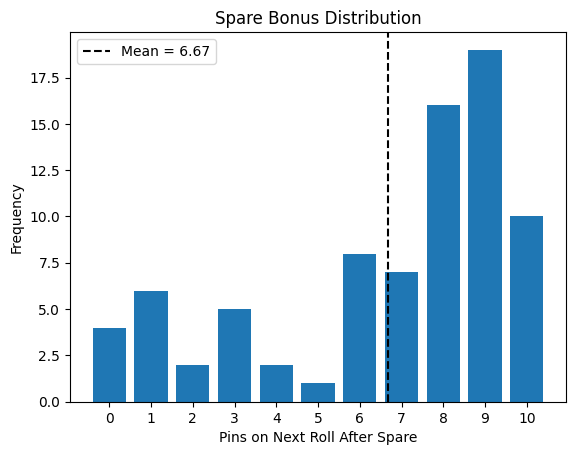

In [48]:
fig = plot_spare_bonus_distribution(games)

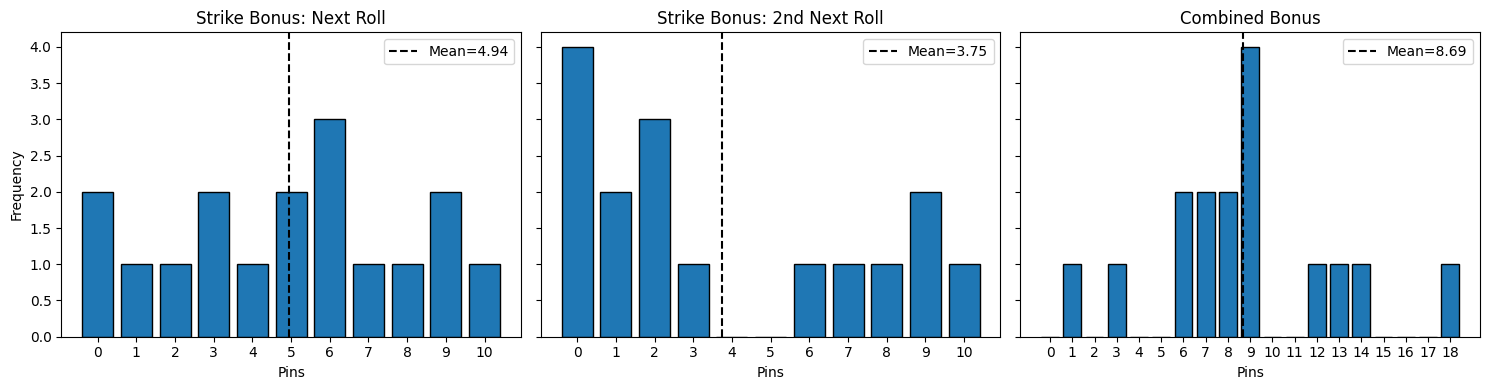

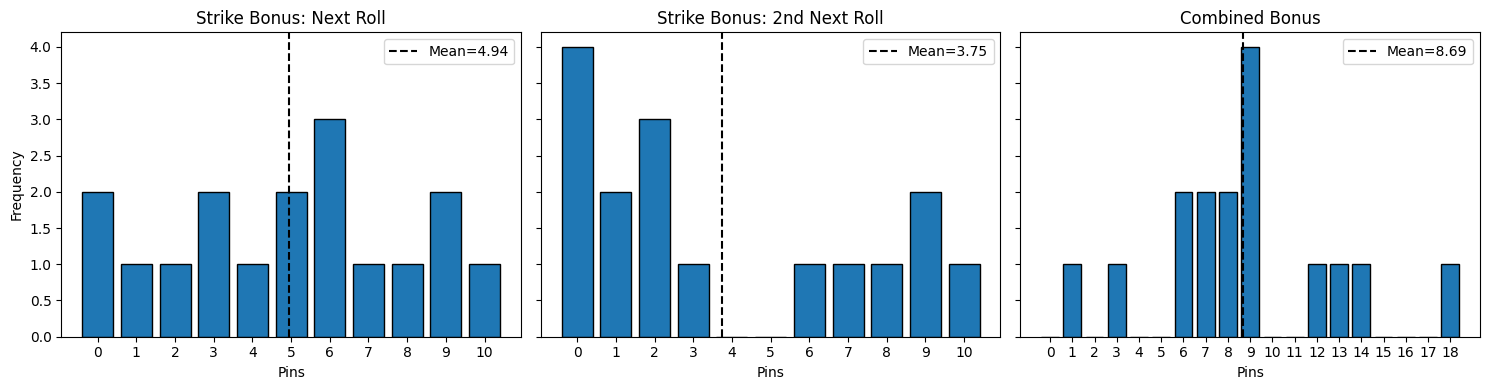

In [47]:
plot_strike_bonus_distributions(games)